# The Relation Between Runs and Wins

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting_utils import plot_regression

sns.set_theme(style='darkgrid', palette='deep')

## Load Data

Teams win by outscoring opponents. Exploring this relationship using MLB data from 2001-2024.

Data source: [Lahman Baseball Database](https://sabr.org/lahman-database/)

In [2]:
teams = pd.read_csv('../data/lahman/Teams.csv')

## The Teams Table

The Lahman database contains team statistics dating back to 1871. This notebook 
focuses on seasons from 2001-2024 to analyze modern baseball. 

Key variables:
- `W`, `L` - Wins and losses
- `R`, `RA` - Runs scored and runs allowed
- `G` - Games played

In [3]:
teams.tail(3)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
3581,2024,AL,TEX,TEX,W,3,162,81.0,78,84,...,106.0,0.987,Texas Rangers,Globe Life Field,2651553.0,96.0,96.0,TEX,TEX,TEX
3582,2024,AL,TOR,TOR,E,5,162,81.0,74,88,...,125.0,0.984,Toronto Blue Jays,Rogers Centre,2681236.0,103.0,103.0,TOR,TOR,TOR
3583,2024,NL,WAS,WSN,E,4,162,81.0,71,91,...,155.0,0.981,Washington Nationals,Nationals Park,1967302.0,96.0,98.0,WSN,MON,WAS


Filter to recent seasons and extract key variables:
- **R**: Runs scored
- **RA**: Runs allowed
- **W/L**: Wins and losses

In [4]:
my_teams = teams.loc[teams['yearID'] > 2000, ['teamID', 'name', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0


### Creating Key Metrics

**Run Differential (RD)**: The difference between runs scored and runs allowed. 
Teams that outscore opponents have positive run differentials.

**Winning Percentage (Wpct)**: Fraction of games won. In a 162-game season, 
a .500 team wins 81 games.

In [5]:
my_teams['RD'] = my_teams['R'] - my_teams['RA']
my_teams['Wpct'] = my_teams['W'] / (my_teams['W'] + my_teams['L'])
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA,RD,Wpct
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0,-39.0,0.462963
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0,141.0,0.567901
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0,86.0,0.543210
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0,-142.0,0.391304
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0,27.0,0.509317


## Linear Regression:

$$Wpct = a + b \times RD + \epsilon$$


Plot relationship between **Run Differential (RD)** and **Winning Percentage (Wpct)** for 2001-2024 seasons

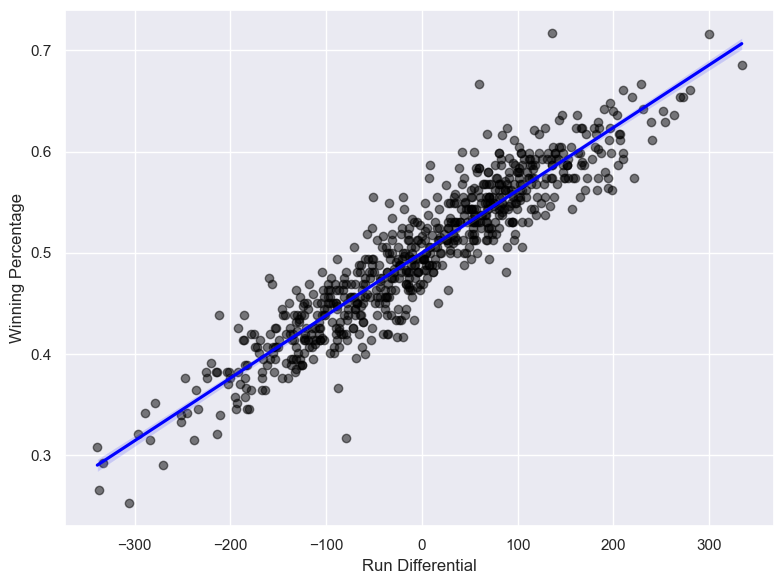

In [6]:
plot_regression(data=my_teams, x='RD', y='Wpct', xlabel='Run Differential', ylabel='Winning Percentage')
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression model
X = my_teams[['RD']].values
y = my_teams['Wpct'].values

linfit = LinearRegression()
linfit.fit(X, y)

# Display coefficients
intercept = linfit.intercept_
slope = linfit.coef_[0]

print(f"Intercept (a): {intercept:.6f}")
print(f"Slope (b): {slope:.6f}")
print(f"Equation: Wpct = {intercept:.6f} + {slope:.6f} * RD")

Intercept (a): 0.499988
Slope (b): 0.000619
Equation: Wpct = 0.499988 + 0.000619 * RD


### Interpreting the Linear Model

The model estimates:
- **Intercept ≈ 0.500**: A team with RD=0 is expected to win half its games
- **Slope ≈ 0.000619**: Each additional run of differential increases winning 
  percentage by 0.000619

**Practical interpretation**: In a 162-game season, a 10-run improvement in 
run differential corresponds to approximately one additional win 
(0.000619 × 10 × 162 ≈ 1 win).

In [13]:
from sklearn.metrics import root_mean_squared_error

# Calculate predictions and residuals
my_teams['predicted_Wpct'] = linfit.predict(X)
my_teams['residuals'] = my_teams['Wpct'] - my_teams['predicted_Wpct']

# Calculate R-squared
r_squared = linfit.score(X, y)
print(f"R-squared: {r_squared:.4f}")

# Calculate RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y, my_teams['predicted_Wpct'])
print(f"RMSE: {rmse:.4f}")
print(f"This means predictions are accurate within about {rmse*100:.1f} percentage points")

R-squared: 0.8664
RMSE: 0.0277
This means predictions are accurate within about 2.8 percentage points


### Understanding Residuals

**Residuals** measure prediction error which is the difference between actual and 
predicted winning percentage. Large positive residuals indicate teams that 
won more than expected and large negative residuals indicate underperformers.

We calculate RMSE (Root Mean Square Error) to measure average prediction error.

In [9]:
# View some examples with predictions and residuals
my_teams[['name', 'yearID', 'W', 'L', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']].sample(10)

,name,yearID,W,L,RD,Wpct,predicted_Wpct,residuals
3354,Houston Astros,2017,101,61,196.0,0.623457,0.621249,0.002208
2982,Texas Rangers,2004,89,73,66.0,0.549383,0.540820,0.008562
3158,San Francisco Giants,2010,92,70,114.0,0.567901,0.570517,-0.002616
3372,Toronto Blue Jays,2017,76,86,-91.0,0.469136,0.443688,0.025448
3234,Houston Astros,2013,51,111,-238.0,0.314815,0.352742,-0.037927
3282,Toronto Blue Jays,2014,83,79,37.0,0.512346,0.522879,-0.010533
3016,Baltimore Orioles,2006,70,92,-131.0,0.432099,0.418941,0.013158
3264,Houston Astros,2014,70,92,-94.0,0.432099,0.441832,-0.009733
3362,New York Mets,2017,70,92,-128.0,0.432099,0.420797,0.011302
3371,Texas Rangers,2017,78,84,-17.0,0.481481,0.489470,-0.007989


## Residual Plot

Figure 4.2 displays a plot of the residuals against the run differential. We'll highlight the 6 teams with the largest residuals.

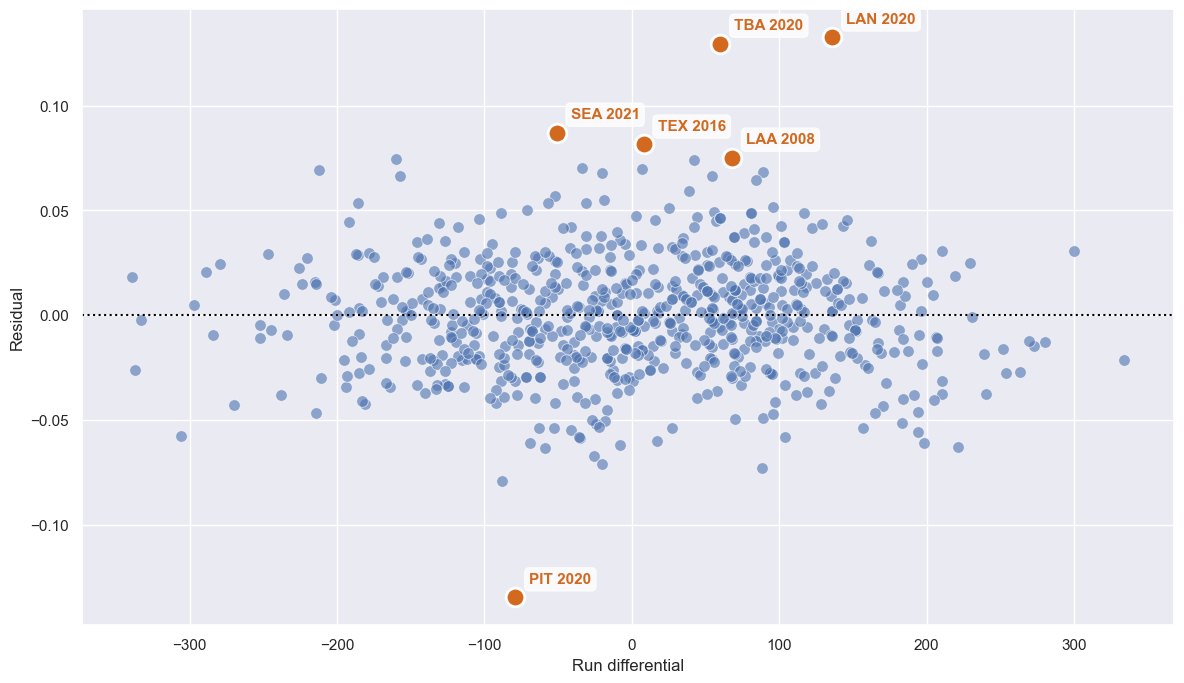

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=my_teams, x='RD', y='residuals', alpha=0.6, color='#4C72B0', s=70, ax=ax)
ax.axhline(y=0, linestyle=':', color='black', linewidth=1.5)
ax.set_xlabel('Run differential', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)

# Find 5 highest residuals and 1 lowest residual
top_5 = my_teams.nlargest(5, 'residuals')
bottom_1 = my_teams.nsmallest(1, 'residuals')
outlier_teams = pd.concat([top_5, bottom_1])

# Highlight and label these teams
for _, row in outlier_teams.iterrows():
    ax.scatter(row['RD'], row['residuals'], color='#D2691E', s=180, zorder=5, edgecolors='white', linewidth=2)
    ax.annotate(f"{row['teamID']} {int(row['yearID'])}", 
               xy=(row['RD'], row['residuals']),
               xytext=(10, 10), 
               textcoords='offset points',
               color='#D2691E', 
               fontsize=11,
               fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 2020 Season Outliers

Interesting to note that several of the largest residuals occurred during the shortened and unpredictable 2020 COVID season (60 games vs. typical 162). Small sample sizes and unique circumstances made winning percentages less predictable from run differential.

In [15]:
outlier_teams[['teamID', 'name', 'yearID', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']]

,teamID,name,yearID,RD,Wpct,predicted_Wpct,residuals
3447,LAN,Los Angeles Dodgers,2020,136.0,0.716667,0.584128,0.132539
3460,TBA,Tampa Bay Rays,2020,60.0,0.666667,0.537108,0.129558
3487,SEA,Seattle Mariners,2021,-51.0,0.555556,0.468435,0.087120
3341,TEX,Texas Rangers,2016,8.0,0.586420,0.504937,0.081483
3087,LAA,Los Angeles Angels of Anaheim,2008,68.0,0.617284,0.542058,0.075226
3455,PIT,Pittsburgh Pirates,2020,-79.0,0.316667,0.451112,-0.134445
